In [561]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

In [419]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [420]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [421]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [422]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

<BarContainer object of 2 artists>

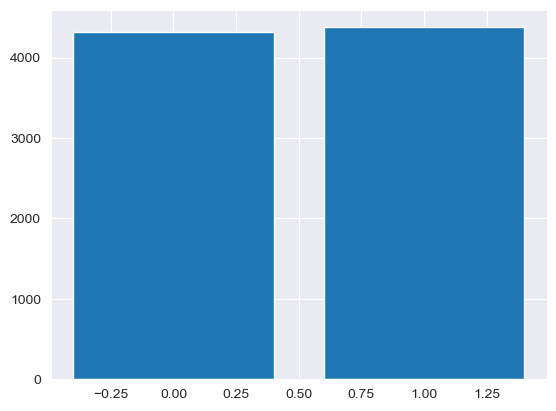

In [423]:
plt.bar(train['Transported'].value_counts().to_dict().keys(), train['Transported'].value_counts().to_dict().values())

<Axes: xlabel='Age', ylabel='Count'>

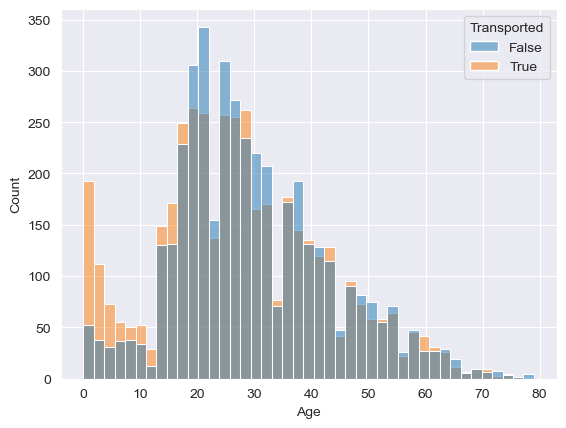

In [424]:
sns.histplot(data=train, x='Age', hue='Transported')

In [425]:
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train['TotalSpent'] = train[exp_feats].sum(axis=1)
test['TotalSpent'] = test[exp_feats].sum(axis=1)

(0.0, 0.001)

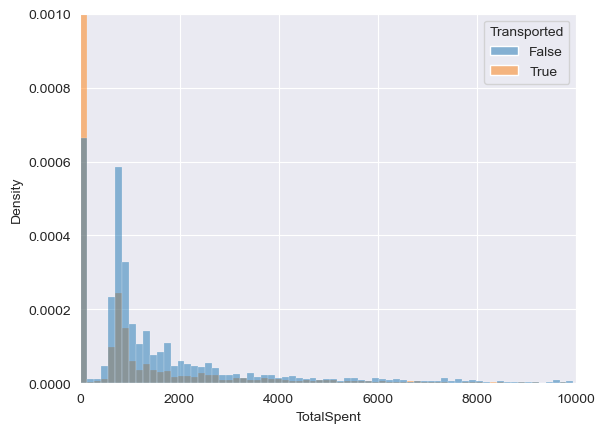

In [426]:
sns.histplot(data=train, x='TotalSpent', hue='Transported', stat='density')
plt.xlim([0, 10000])
plt.ylim([0, 0.001])

In [427]:
train['NoSpent'] = (train['TotalSpent'] == 0).astype(int)
test['NoSpent'] = (test['TotalSpent'] == 0).astype(int)

<Axes: xlabel='HomePlanet', ylabel='count'>

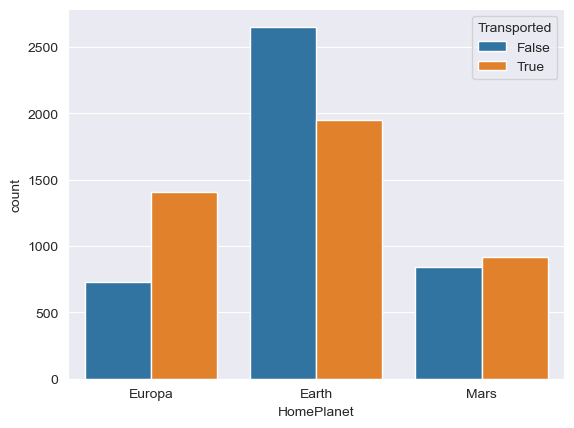

In [428]:
sns.countplot(data=train, x='HomePlanet', hue='Transported')

<Axes: xlabel='Destination', ylabel='count'>

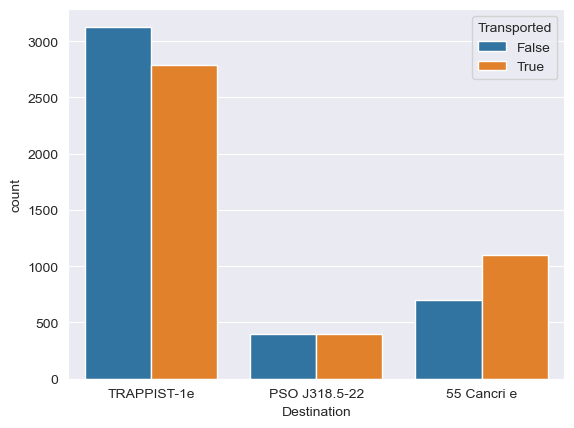

In [429]:
sns.countplot(data=train, x='Destination', hue='Transported')

<Axes: xlabel='CryoSleep', ylabel='count'>

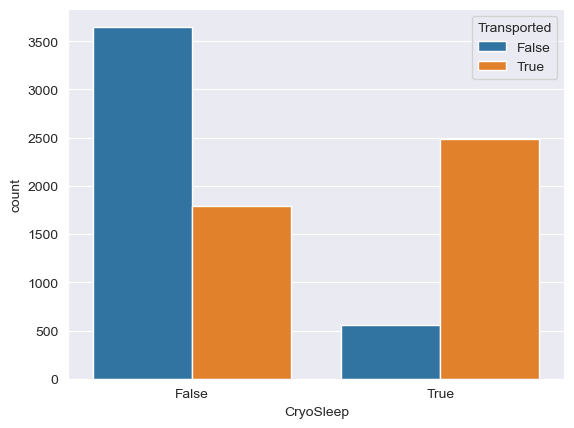

In [430]:
sns.countplot(data=train, x='CryoSleep', hue='Transported')

<Axes: xlabel='NoSpent', ylabel='count'>

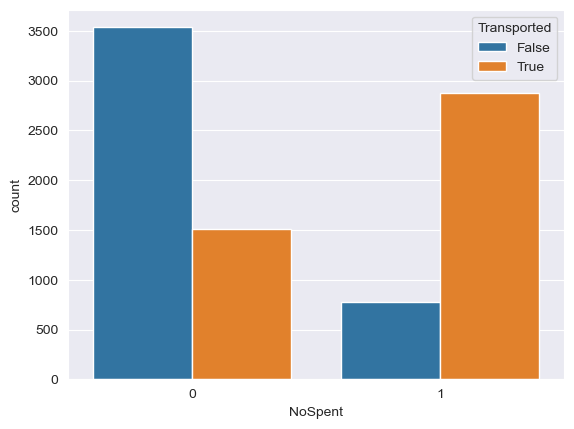

In [431]:
sns.countplot(data=train, x='NoSpent', hue='Transported')

<Axes: xlabel='VIP', ylabel='count'>

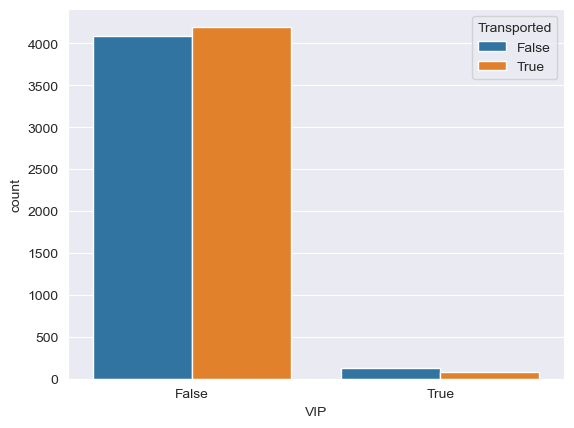

In [432]:
sns.countplot(data=train, x='VIP', hue='Transported')

<Axes: xlabel='NoSpent', ylabel='count'>

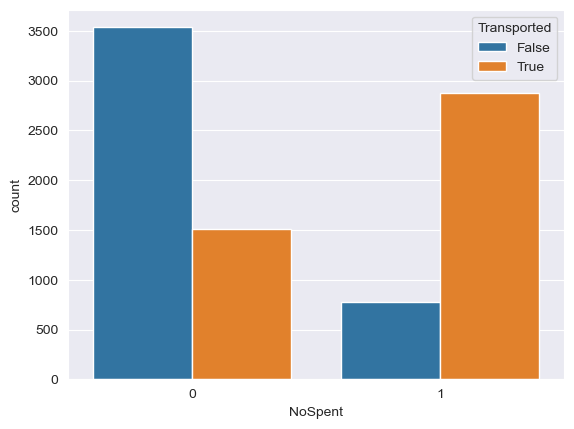

In [433]:
sns.countplot(data=train, x='NoSpent', hue='Transported')

In [434]:
def age_category(data):
    data['AgeGroup'] = np.nan
    data.loc[data['Age'] < 20, 'AgeGroup'] = 'young'
    data.loc[(20 <= data['Age']) & (data['Age'] < 40), 'AgeGroup'] = 'middle'
    data.loc[40 <= data['Age'], 'AgeGroup'] = 'old'

In [435]:
age_category(train)
age_category(test)

<Axes: xlabel='AgeGroup', ylabel='count'>

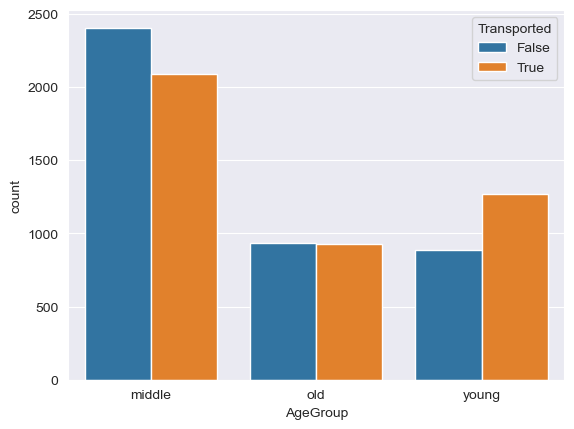

In [436]:
sns.countplot(data=train, x='AgeGroup', hue='Transported')

In [437]:
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

In [438]:
groups_train = train['PassengerId'].apply(lambda x: x.split('_')[0]).value_counts().to_dict()
groups_test = test['PassengerId'].apply(lambda x: x.split('_')[0]).value_counts().to_dict()

In [439]:
train['GroupSize'] = train['PassengerId'].apply(lambda x: groups_train[x.split('_')[0]])
test['GroupSize'] = test['PassengerId'].apply(lambda x: groups_test[x.split('_')[0]])

In [440]:
train['Solo'] = (train['GroupSize'] == 1).astype(int)
test['Solo'] = (test['GroupSize'] == 1).astype(int)

<Axes: xlabel='GroupSize', ylabel='count'>

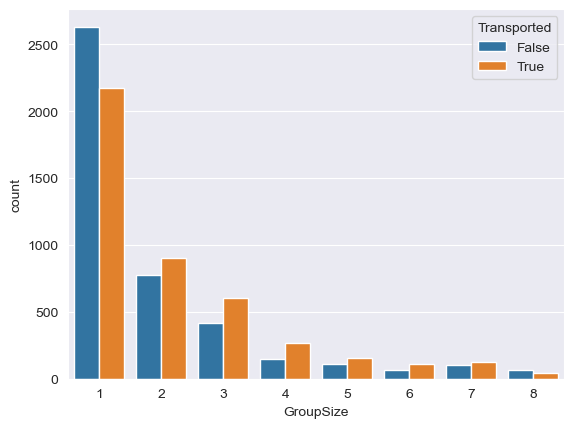

In [441]:
sns.countplot(data=train, x='GroupSize', hue='Transported')

<Axes: xlabel='Solo', ylabel='count'>

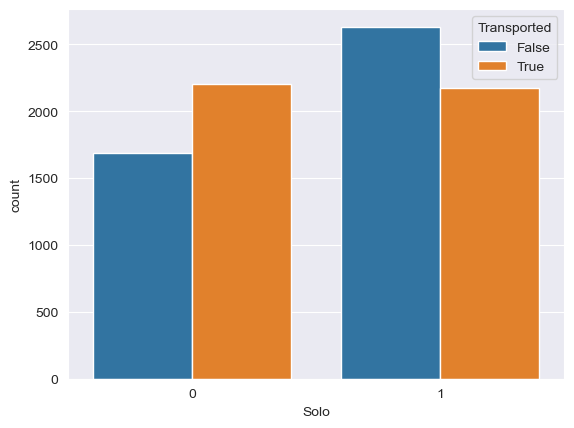

In [442]:
sns.countplot(data=train, x='Solo', hue='Transported')

In [443]:
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

train['Deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Num'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

test['Deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Num'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

train.loc[train['Deck'] == 'Z', 'Deck'] = np.nan
train.loc[train['Num'] == 9999, 'Num'] = np.nan
train.loc[train['Side'] == 'Z', 'Side'] = np.nan

test.loc[test['Deck'] == 'Z', 'Deck'] = np.nan
test.loc[test['Num'] == 9999, 'Num'] = np.nan
test.loc[test['Side'] == 'Z', 'Side'] = np.nan

train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

<Axes: xlabel='Side', ylabel='count'>

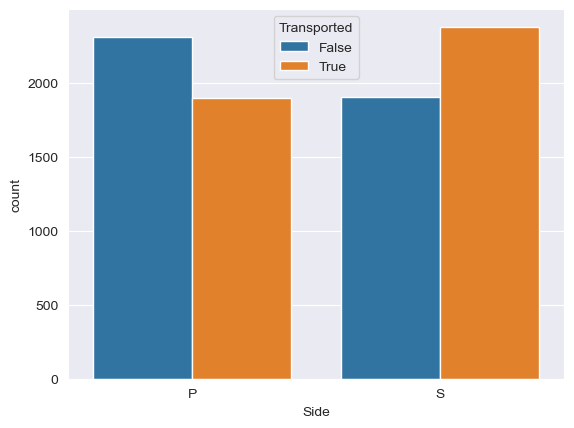

In [444]:
sns.countplot(data=train, x='Side', hue='Transported')

<Axes: xlabel='Deck', ylabel='count'>

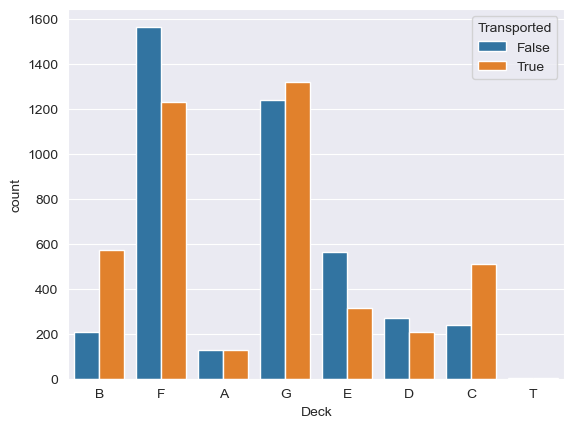

In [445]:
sns.countplot(data=train, x='Deck', hue='Transported')

(0.0, 2000.0)

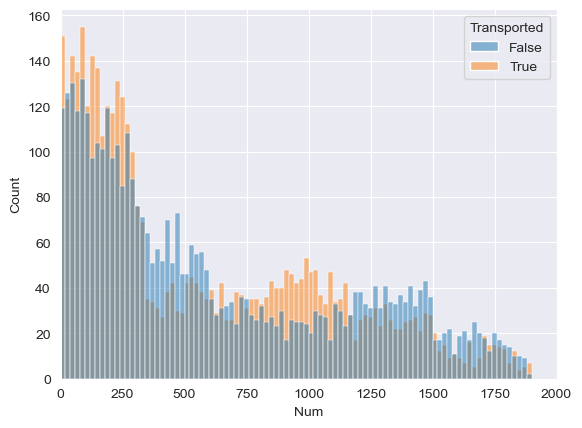

In [446]:
sns.histplot(data=train, x='Num', hue='Transported', binwidth=20)
plt.xlim([0, 2000])

In [447]:
train['Cabin_region1']=(train['Num']<300).astype(int)
train['Cabin_region2']=((train['Num']>=300) & (train['Num']<600)).astype(int)
train['Cabin_region3']=((train['Num']>=600) & (train['Num']<900)).astype(int)
train['Cabin_region4']=((train['Num']>=900) & (train['Num']<1200)).astype(int)
train['Cabin_region5']=((train['Num']>=1200) & (train['Num']<1500)).astype(int)
train['Cabin_region6']=((train['Num']>=1500) & (train['Num']<1800)).astype(int)
train['Cabin_region7']=(train['Num']>=1800).astype(int)


test['Cabin_region1']=(test['Num']<300).astype(int)
test['Cabin_region2']=((test['Num']>=300) & (test['Num']<600)).astype(int)
test['Cabin_region3']=((test['Num']>=600) & (test['Num']<900)).astype(int)
test['Cabin_region4']=((test['Num']>=900) & (test['Num']<1200)).astype(int)
test['Cabin_region5']=((test['Num']>=1200) & (test['Num']<1500)).astype(int)
test['Cabin_region6']=((test['Num']>=1500) & (test['Num']<1800)).astype(int)
test['Cabin_region7']=(test['Num']>=1800).astype(int)

In [448]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Deck,Num,Side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,B,0.0,P,1,0,0,0,0,0,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,F,0.0,S,1,0,0,0,0,0,0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,A,0.0,S,1,0,0,0,0,0,0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,A,0.0,S,1,0,0,0,0,0,0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,F,1.0,S,1,0,0,0,0,0,0


<Axes: xlabel='CabinRegion', ylabel='count'>

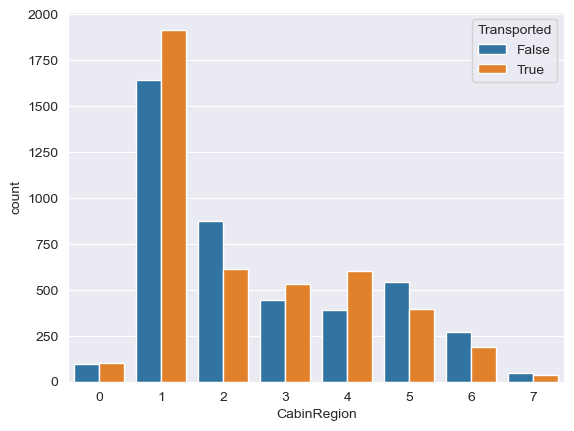

In [449]:
table = pd.DataFrame()
table['CabinRegion'] = train['Cabin_region1'] + train['Cabin_region2'] * 2 + train['Cabin_region3'] * 3 + train['Cabin_region4'] * 4 + train['Cabin_region5'] * 5 + train['Cabin_region6'] * 6 + train['Cabin_region7'] * 7
table['Transported'] = train['Transported']
sns.countplot(data=table, x='CabinRegion',  hue='Transported')

In [450]:
train['Name'].fillna('lol lol', inplace=True)
test['Name'].fillna('lol lol', inplace=True)

train['LastName'] = train['Name'].str.split().str[-1]
test['LastName'] = test['Name'].str.split().str[-1]

familie = pd.concat([train['LastName'], test['LastName']]).value_counts().to_dict()
train['FamilySize'] = train['LastName'].apply(lambda x: familie[x])
test['FamilySize'] = test['LastName'].apply(lambda x: familie[x])

train.loc[train['LastName']=='lol','LastName']=np.nan
train.loc[train['FamilySize']>100,'FamilySize']=np.nan
test.loc[test['LastName']=='lol','LastName']=np.nan
test.loc[test['FamilySize']>100,'FamilySize']=np.nan

train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

<Axes: xlabel='FamilySize', ylabel='count'>

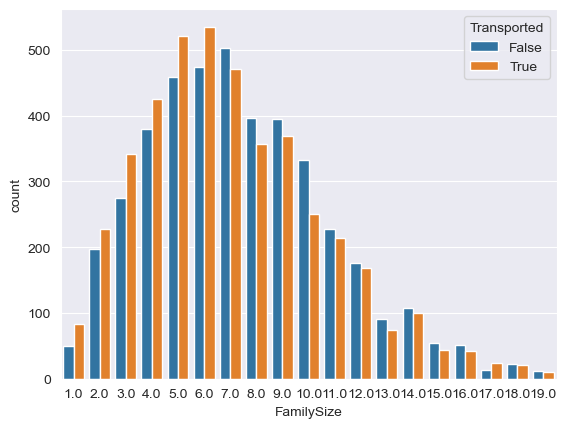

In [451]:
sns.countplot(data=train, x='FamilySize', hue='Transported')

In [452]:
y = train['Transported'].copy().astype(int)
train.drop('Transported', axis=1, inplace=True)

In [453]:
data = pd.concat([test, train], axis=0).reset_index(drop=True)

In [454]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    12970 non-null  object 
 1   HomePlanet     12682 non-null  object 
 2   CryoSleep      12660 non-null  object 
 3   Destination    12696 non-null  object 
 4   Age            12700 non-null  float64
 5   VIP            12674 non-null  object 
 6   RoomService    12707 non-null  float64
 7   FoodCourt      12681 non-null  float64
 8   ShoppingMall   12664 non-null  float64
 9   Spa            12686 non-null  float64
 10  VRDeck         12702 non-null  float64
 11  TotalSpent     12970 non-null  float64
 12  NoSpent        12970 non-null  int32  
 13  AgeGroup       12700 non-null  object 
 14  Group          12970 non-null  int32  
 15  GroupSize      12970 non-null  int64  
 16  Solo           12970 non-null  int32  
 17  Deck           12671 non-null  object 
 18  Num   

In [455]:
GHP_gb = data.groupby(['Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


<Axes: ylabel='Count'>

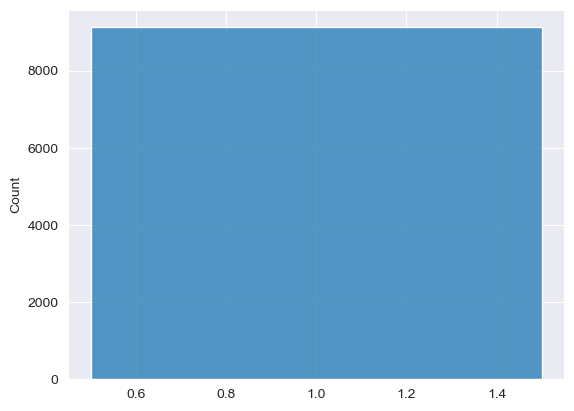

In [456]:
tabel = (GHP_gb > 0).sum(axis=1)
sns.histplot(tabel)

In [457]:
before = data['HomePlanet'].isna().sum()
index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index
data.loc[index,'HomePlanet']=data.iloc[index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])
print(before, data['HomePlanet'].isna().sum())

288 157


<Axes: xlabel='Deck', ylabel='HomePlanet'>

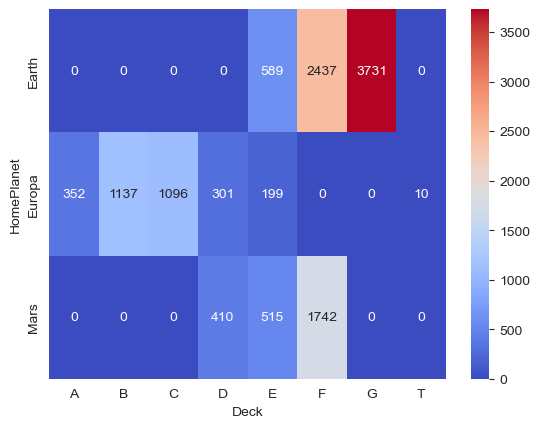

In [458]:
CHP_gb = data.groupby(['Deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
sns.heatmap(CHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [459]:
before = data['HomePlanet'].isna().sum()
data.loc[(data['HomePlanet'].isna()) & (data['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'
data.loc[(data['HomePlanet'].isna()) & (data['Deck'].isin(['G'])), 'HomePlanet'] = 'Earth'
print(before, data['HomePlanet'].isna().sum())

157 94


<Axes: ylabel='count'>

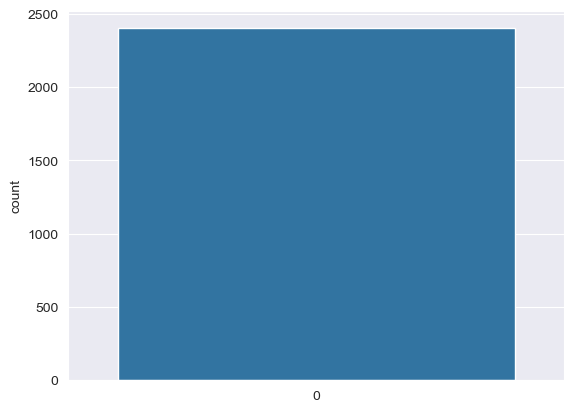

In [460]:
CHP_gb = data.groupby(['LastName', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
sns.countplot(data=((CHP_gb > 0).sum(axis=1)))

In [461]:
before = data['HomePlanet'].isna().sum()
index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['LastName']).isin(CHP_gb.index)].index
data.loc[index,'HomePlanet']=data.iloc[index,:]['LastName'].map(lambda x: CHP_gb.idxmax(axis=1)[x])
print(before, data['HomePlanet'].isna().sum())

94 10


In [462]:
data[data['HomePlanet'].isna()][['HomePlanet','Destination', 'Deck']]

,HomePlanet,Destination,Deck
276,NaN,TRAPPIST-1e,E
1890,NaN,TRAPPIST-1e,D
3220,NaN,TRAPPIST-1e,E
3858,NaN,TRAPPIST-1e,F
4032,NaN,TRAPPIST-1e,D
6551,NaN,TRAPPIST-1e,D
6908,NaN,TRAPPIST-1e,F
7368,NaN,TRAPPIST-1e,F
8825,NaN,TRAPPIST-1e,F
10039,NaN,TRAPPIST-1e,F


<Axes: xlabel='Destination', ylabel='HomePlanet'>

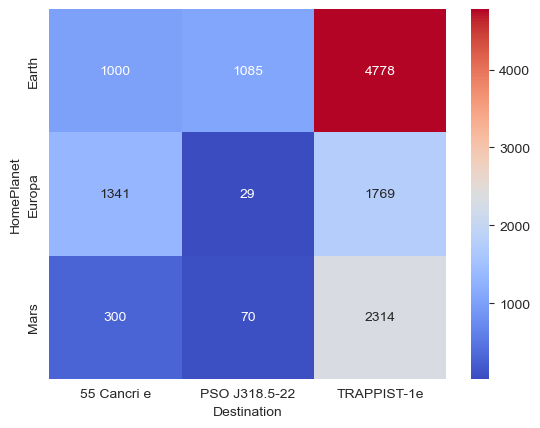

In [463]:
DHP_gb = data.groupby(['Destination', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
sns.heatmap(DHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [464]:
before = data['HomePlanet'].isna().sum()
data.loc[(data['HomePlanet'].isna()) & ~(data['Deck'] == 'D'), 'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'D'), 'HomePlanet'] = 'Mars'
print(before, data['HomePlanet'].isna().sum())

10 0


In [465]:
data.loc[(data['Destination'].isna()), 'Destination'] = 'TRAPPIST-1e'

<Axes: ylabel='Count'>

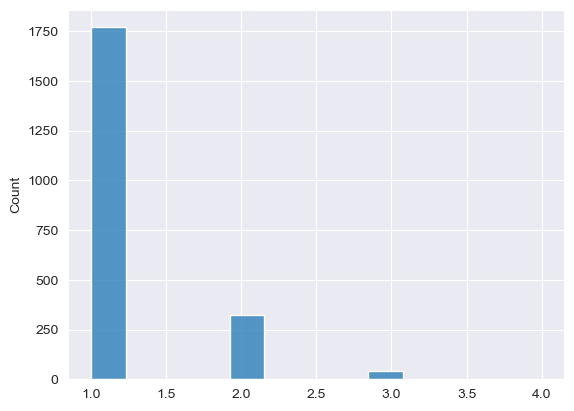

In [466]:
GSN_gb=data[data['GroupSize']>1].groupby(['Group','LastName'])['LastName'].size().unstack().fillna(0)
sns.histplot(data=((GSN_gb > 0).sum(axis=1)))

In [467]:
before = data['LastName'].isna().sum()
index = data[data['LastName'].isna()][(data[data['LastName'].isna()]['Group']).isin(GSN_gb.index)].index
data.loc[index,'LastName']=data.iloc[index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])
print(before, data['LastName'].isna().sum())

294 155


In [468]:
data['LastName'].fillna('Unknown', inplace=True)
data['FamilySize'] = data['LastName'].map(lambda x: data['LastName'].value_counts()[x])
data.loc[data['LastName'] == 'Unknown', 'LastName'] = np.nan
data.loc[data['FamilySize']>100,'FamilySize']=0

<Axes: ylabel='Count'>

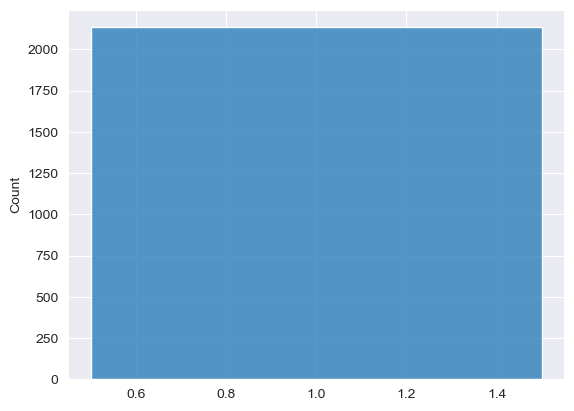

In [469]:
GDC_gb = data[data['GroupSize']> 1].groupby(['Group', 'Side'])['Side'].size().unstack().fillna(0)
sns.histplot((GDC_gb > 0).sum(axis=1))

<Axes: ylabel='Count'>

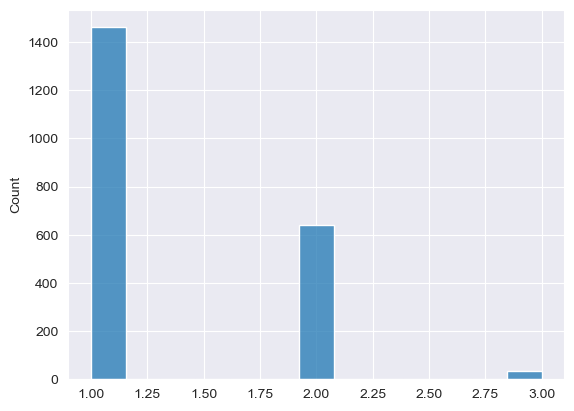

In [470]:
GCN_gb = data[data['GroupSize']> 1].groupby(['Group', 'Deck'])['Deck'].size().unstack().fillna(0)
sns.histplot((GCN_gb > 0).sum(axis=1))

<Axes: ylabel='Count'>

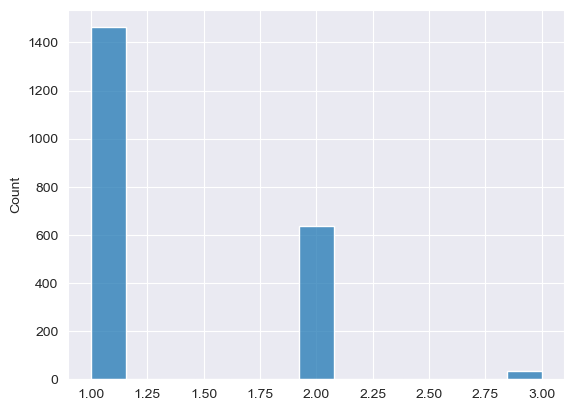

In [471]:
GCS_gb = data[data['GroupSize']> 1].groupby(['Group', 'Num'])['Num'].size().unstack().fillna(0)
sns.histplot((GCS_gb > 0).sum(axis=1))

<Axes: ylabel='Count'>

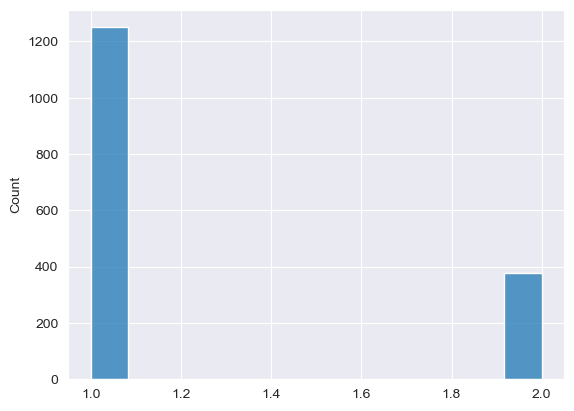

In [472]:
SLN_gb = data[data['GroupSize']> 1].groupby(['LastName', 'Side'])['Side'].size().unstack().fillna(0)
sns.histplot((SLN_gb > 0).sum(axis=1))

In [473]:
before = data['Side'].isna().sum()
index = data[data['Side'].isna()][(data[data['Side'].isna()]['Group']).isin(GDC_gb.index)].index
data.loc[index,'Side']=data.iloc[index,:]['Group'].map(lambda x: GDC_gb.idxmax(axis=1)[x])
print(before, data['Side'].isna().sum())

299 162


In [474]:
before = data['Side'].isna().sum()
index = data[data['Side'].isna()][(data[data['Side'].isna()]['LastName']).isin(SLN_gb.index)].index
data.loc[index,'Side']=data.iloc[index,:]['LastName'].map(lambda x: SLN_gb.idxmax(axis=1)[x])
print(before, data['Side'].isna().sum())

162 66


In [475]:
data.drop('LastName', axis=1, inplace=True)

In [476]:
before = data['Side'].isna().sum()
data.loc[data['Side'].isna(), 'Side'] = 'Z'
print(before, data['Side'].isna().sum())

66 0


In [477]:
SLN_gb = data[data['GroupSize']> 1].groupby(['Group', 'Deck'])['Deck'].size().unstack().fillna(0)
(SLN_gb > 0).sum(axis=1).value_counts()

1    1461
2     640
3      33
dtype: int64

In [478]:
before = data['Deck'].isna().sum()
index = data[data['Deck'].isna()][(data[data['Deck'].isna()]['Group']).isin(SLN_gb.index)].index
data.loc[index,'Deck']=data.iloc[index,:]['Group'].map(lambda x: SLN_gb.idxmax(axis=1)[x])
print(before, data['Deck'].isna().sum())

299 162


In [479]:
data.groupby(['HomePlanet', 'Destination', 'Solo', 'Deck'])['Deck'].size().unstack().fillna(0)

Deck                               A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Deck                                G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

In [480]:
before = data['Deck'].isna().sum()
index = data.loc[data['Deck'].isna(), 'Deck'].index
data.loc[data['Deck'].isna(), 'Deck'] = data.groupby(['HomePlanet', 'Destination', 'Solo'])['Deck'].transform(lambda x:x.fillna(pd.Series.mode(x)[0]))[index]
print(before, data['Deck'].isna().sum())

162 0


<Axes: xlabel='Num', ylabel='Group'>

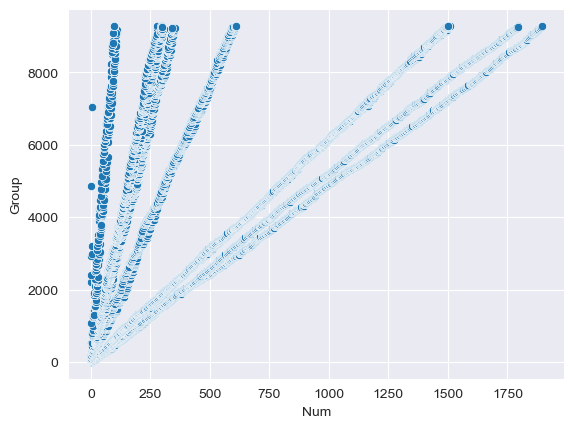

In [481]:
sns.scatterplot(x=data['Num'], y=data['Group'])

In [482]:
CN_bef=data['Num'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN=data.loc[~(data['Num'].isna()) & (data['Deck']==deck),'Group']
    y_CN=data.loc[~(data['Num'].isna()) & (data['Deck']==deck),'Num']
    X_test_CN=data.loc[(data['Num'].isna()) & (data['Deck']==deck),'Group']

    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))

    # Fill missing values with predictions
    data.loc[(data['Num'].isna()) & (data['Deck']==deck),'Num']=preds_CN.astype(int)

# Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Num'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


In [483]:
data['Cabin_region1']=(data['Num']<300).astype(int)
data['Cabin_region2']=((data['Num']>=300) & (data['Num']<600)).astype(int)
data['Cabin_region3']=((data['Num']>=600) & (data['Num']<900)).astype(int)
data['Cabin_region4']=((data['Num']>=900) & (data['Num']<1200)).astype(int)
data['Cabin_region5']=((data['Num']>=1200) & (data['Num']<1500)).astype(int)
data['Cabin_region6']=((data['Num']>=1500) & (data['Num']<1800)).astype(int)
data['Cabin_region7']=(data['Num']>=1800).astype(int)

In [484]:
V_bef=data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(),'VIP']=False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


In [485]:
data.groupby(['HomePlanet','NoSpent','Solo','Deck'])['Age'].median().unstack().fillna(0)

Deck                        A     B     C     D     E     F     G     T
HomePlanet NoSpent Solo                                                
Earth      0       0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                   1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1       0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                   1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0       0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                   1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1       0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                   1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0       0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                   1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1       0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                   1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [486]:
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
before = data[exp_feats].isna().sum().sum()
index = data.loc[(data['Age'].isna()), 'Age'].index
data.loc[(data['Age'].isna()), 'Age'] = data.groupby(['HomePlanet','NoSpent','Solo','Deck'])['Age'].transform(lambda x: x.fillna(x.median()))[index]
print(before, data['Age'].isna().sum())

1410 0


In [487]:
age_category(data)

In [488]:
data.groupby(['NoSpent', 'CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
NoSpent,,
0,7339.0,0.0
1,740.0,4581.0


In [489]:
before = data['CryoSleep'].isna().sum()
index = data.loc[(data['CryoSleep'].isna()), 'CryoSleep'].index
data.loc[(data['CryoSleep'].isna()) & (data['NoSpent'] == 1), 'CryoSleep'] = False
data.loc[(data['CryoSleep'].isna()) & (data['NoSpent'] == 0), 'CryoSleep'] = True
print(before, data['CryoSleep'].isna().sum())

310 0


In [490]:
before = data[exp_feats].isna().sum().sum()

for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col] = 0

print('#Expenditure missing values before:',before)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 861


In [491]:
E_bef=data[exp_feats].isna().sum().sum()

# Fill remaining missing values using the median
for col in exp_feats:
    na_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','AgeGroup'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 861
#Expenditure missing values after: 0


In [492]:
data['TotalSpent']=data[exp_feats].sum(axis=1)
data['NoSpent']=(data['TotalSpent']==0).astype(int)

In [493]:
data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
TotalSpent       0
NoSpent          0
AgeGroup         0
Group            0
GroupSize        0
Solo             0
Deck             0
Num              0
Side             0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
FamilySize       0
dtype: int64

In [531]:
X = data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

In [532]:
X.drop(['PassengerId', 'AgeGroup', 'Group', 'GroupSize', 'Num'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'AgeGroup', 'Group', 'GroupSize', 'Num'], axis=1, inplace=True)

In [533]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
    remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

# Print new shape
print('Training set shape:', X.shape)

Training set shape: (8693, 36)


D:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [534]:
X.shape

(8693, 36)

In [535]:
KNN_grid = {'n_neighbors': [3, 5, 7, 9, 17, 25, 55, 105, 155, 205, 255, 305], 'p': [1, 2]}

kNN = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=KNN_grid, verbose=0, n_jobs=-1)
kNN.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 17, 25, 55, 105, 155, 205,
                                         255, 305],
                         'p': [1, 2]})

In [539]:
kNN.best_estimator_

KNeighborsClassifier(n_neighbors=25, p=1)

In [536]:
cross_val_score(kNN.best_estimator_, X, y, cv=5, verbose=0, n_jobs=-1).mean()

0.7843133660801316

In [538]:
SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf', 'poly'],
            'degree': [2,3],
            'gamma': ['scale', 'auto', 0.1, 0.2, 0.01, 0.02, 0.001, 0.005]}

svm = GridSearchCV(estimator=SVC(), param_grid=SVC_grid, verbose=0, n_jobs=-1)
svm.fit(X, y)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5], 'degree': [2, 3],
                         'gamma': ['scale', 'auto', 0.1, 0.2, 0.01, 0.02, 0.001,
                                   0.005],
                         'kernel': ['linear', 'rbf', 'poly']})

In [540]:
svm.best_estimator_

SVC(C=0.5, degree=2, gamma=0.1)

In [550]:
cross_val_score(svm.best_estimator_, X, y, cv=5, verbose=0, n_jobs=-1).mean()

0.7968513576377837

In [551]:
rand_forest_grid = {'n_estimators':[50, 100, 150, 200, 300, 400, 500], 'max_depth': [20, 40, 50, 100, 120, 150], 'max_features' : ['auto', 'sqrt', 'log2']}
rand_for = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rand_forest_grid, verbose=0, n_jobs=-1)
rand_for.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20, 40, 50, 100, 120, 150],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 150, 200, 300, 400, 500]})

In [552]:
cross_val_score(rand_for.best_estimator_, X, y, cv=5, verbose=0, n_jobs=-1).mean()

0.7947812685491112

In [557]:
log_reg_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 'C':[0.2, 0.5, 1, 5, 7, 10, 15, 20]}
log_reg = GridSearchCV(estimator=LogisticRegression(), param_grid=log_reg_grid, verbose=0, n_jobs=-1)
log_reg.fit(X, y)

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' pe

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.2, 0.5, 1, 5, 7, 10, 15, 20],
                          'penalty': ['l1', 'l2', 'elasticnet', None]}])

In [558]:
log_reg.best_estimator_

LogisticRegression(C=0.2)

In [560]:
cross_val_score(log_reg.best_estimator_, X, y, cv=5).mean()

0.7889139757978971

In [566]:
voting = VotingClassifier(estimators=[('kNN', kNN.best_estimator_), ('svm', svm.best_estimator_), ('rand', rand_for.best_estimator_), ('log', log_reg.best_estimator_)], voting='hard')
voting.fit(X,y)

VotingClassifier(estimators=[('kNN', KNeighborsClassifier(n_neighbors=25, p=1)),
                             ('svm', SVC(C=0.5, degree=2, gamma=0.1)),
                             ('rand',
                              RandomForestClassifier(max_depth=120,
                                                     n_estimators=150)),
                             ('log', LogisticRegression(C=0.2))])

In [567]:
cross_val_score(voting, X, y, cv=5)

array([0.76480736, 0.7906843 , 0.80621047, 0.82623705, 0.79689298])

In [568]:
predicted = voting.predict(X_test)

In [569]:
data_test2 = pd.read_csv("data/test.csv")

In [570]:
predicted = list(map(lambda x: False if x == 0 else True, predicted))

In [571]:
output = pd.DataFrame({"PassengerId" : data_test2["PassengerId"], "Transported":predicted})
output.to_csv('submisie.csv', index=False)